In [671]:
# !pip install numpy
# !pip install pandas
# !pip install seaborn 
# !pip install matplotlib
# !pip install scikit-learn
# !pip install scikit-plot
# !pip install scipy
# !pip install plotly
# !pip install xgboost
# !pip install lightgbm
# !pip install category_encoders


In [672]:
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split,cross_val_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.preprocessing import RobustScaler,StandardScaler,MaxAbsScaler,MinMaxScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
import sklearn.metrics as metrics
import category_encoders as ce

import warnings
warnings.simplefilter(action="ignore")
sns.set_theme(palette=sns.color_palette("muted"),style="darkgrid")

In [673]:
df = pd.read_csv("IMDb Movies India.csv",encoding='latin-1')

In [674]:
df.sample()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
3883,Dil Ne Ikaar Kiya,(1992),NaN,Romance,NaN,NaN,Partho Ghosh,Suparna Anand,Ravi Behl,Rita Bhaduri


In [675]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [676]:
df.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [677]:
df= df.dropna(subset=["Year","Genre","Director","Actor 1","Actor 2","Actor 3","Rating"])

In [678]:
df = df.dropna().reset_index(drop=True)

In [679]:
df.shape

(5659, 10)

In [680]:
df["Duration"] = df.loc[:,"Duration"].str.replace(" min","")
df["Duration"] = pd.to_numeric(data.loc[:,"Duration"])

In [681]:
df["Votes"] = df.loc[:,"Votes"].str.replace(",","")
df["Votes"] = pd.to_numeric(data.loc[:,"Votes"])

In [682]:
df.duplicated(subset=["Name","Year"]).sum()

2

In [683]:
df=df.drop_duplicates(keep="first",subset=["Name","Year"]).reset_index(drop=True)

In [684]:
df.columns

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')

In [685]:
df["Year"] = df.loc[:,"Year"].str.extract(r"(\d{4})")
df["Year"] = pd.to_numeric(data.loc[:,"Year"])

In [686]:
df["Genre"] = df.loc[:,"Genre"].str.replace("Musical","Music")

In [687]:
df["Main_genre"] = df.loc[:,"Genre"].str.extract("(^\w{1,11})")

In [688]:
df["Main_genre"].unique()

array(['Drama', 'Comedy', 'Horror', 'Action', 'Crime', 'Thriller',
       'Adventure', 'Sport', 'Biography', 'Documentary', 'Mystery',
       'Music', 'Romance', 'Fantasy', 'Sci', 'Family', 'History',
       'Animation', 'War'], dtype=object)

In [689]:
df.describe()

,Year,Duration,Rating,Votes
count,5382.000000,5380.000000,5657.000000,5380.000000
mean,1995.588629,132.963011,5.897967,1084.906506
std,19.820375,23.671442,1.381035,2468.880552
min,1931.000000,62.000000,1.100000,5.000000
25%,1982.000000,118.000000,5.000000,29.000000
50%,2000.000000,135.000000,6.100000,115.000000
75%,2013.000000,150.000000,6.900000,715.500000
max,2021.000000,204.000000,10.000000,15835.000000


In [690]:
df = data[(np.abs(stats.zscore(data[['Rating','Votes','Duration']])) < 3).all(axis=1)]
df.shape

(5211, 9)

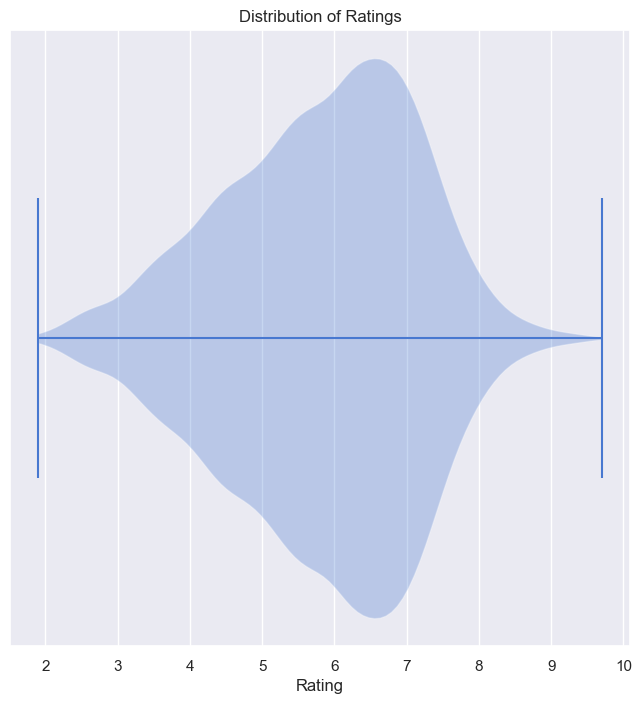

In [691]:
plt.figure(figsize=(8, 8))
plt.violinplot(df['Rating'].dropna(), vert=False)
plt.xlabel('Rating')
plt.yticks([]) 
plt.title('Distribution of Ratings')
plt.show()



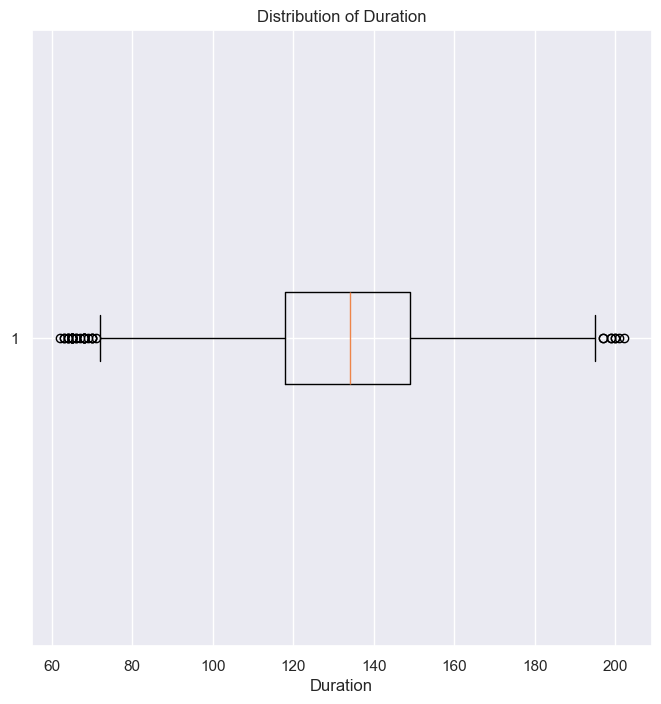

In [692]:
plt.figure(figsize=(8, 8))
plt.boxplot(df['Duration'].dropna(), vert=False)
plt.xlabel('Duration')
plt.title('Distribution of Duration')
plt.show()

In [693]:
df.Genre.value_counts().reset_index()

,Genre,count
0,Drama,823
1,"Drama, Romance",308
2,"Action, Crime, Drama",291
3,"Action, Drama",200
4,Comedy,182
...,...,...
350,"Action, Romance, Comedy",1
351,"Comedy, Family, Music",1
352,"Horror, Drama, Mystery",1
353,"Thriller, Mystery, Family",1


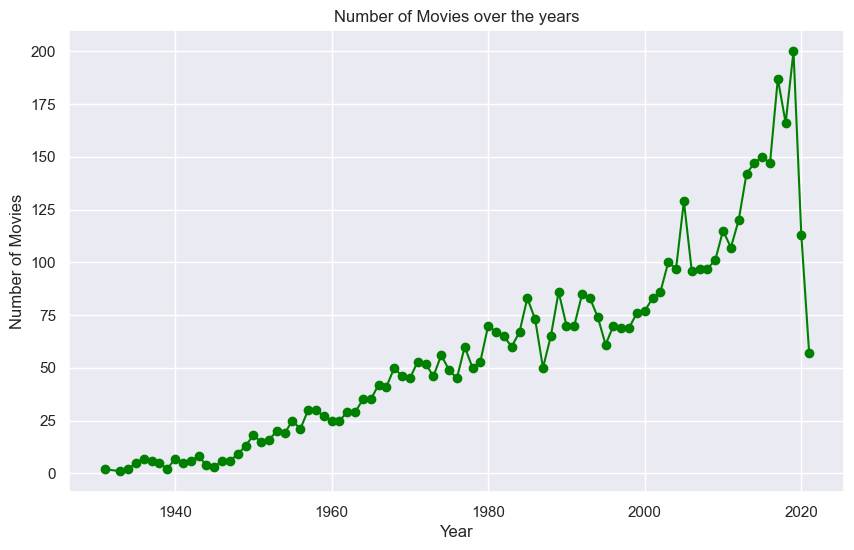

In [694]:
movies_by_year = df["Year"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(movies_by_year.index, movies_by_year.values, marker='o', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies over the years')
plt.grid(True)
plt.show()

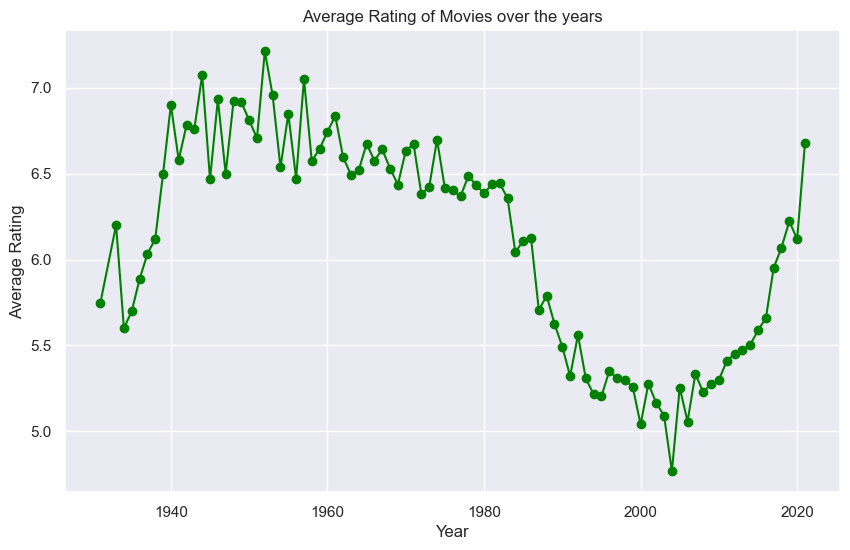

In [695]:
Rating_by_years = df.groupby("Year").agg({"Rating":"mean","Votes":"sum"}).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(Rating_by_years['Year'], Rating_by_years['Rating'], marker='o', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating of Movies over the years')
plt.grid(True)
plt.show()

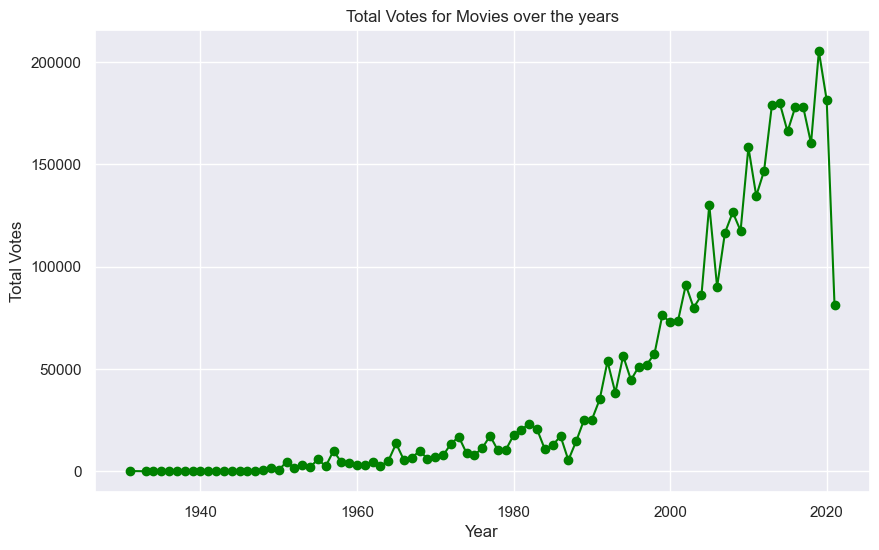

In [696]:
Rating_by_years = df.groupby("Year").agg({"Rating": "mean", "Votes": "sum"}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(Rating_by_years['Year'], Rating_by_years['Votes'], marker='o', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Total Votes')
plt.title('Total Votes for Movies over the years')
plt.grid(True)
plt.show()

In [697]:
def top_10_rating(col):
    return data.groupby(col)["Rating"].agg(["mean","count"])\
    .query("count >=10")\
    .sort_values(by="mean",ascending=False)[:10]\
    .reset_index()

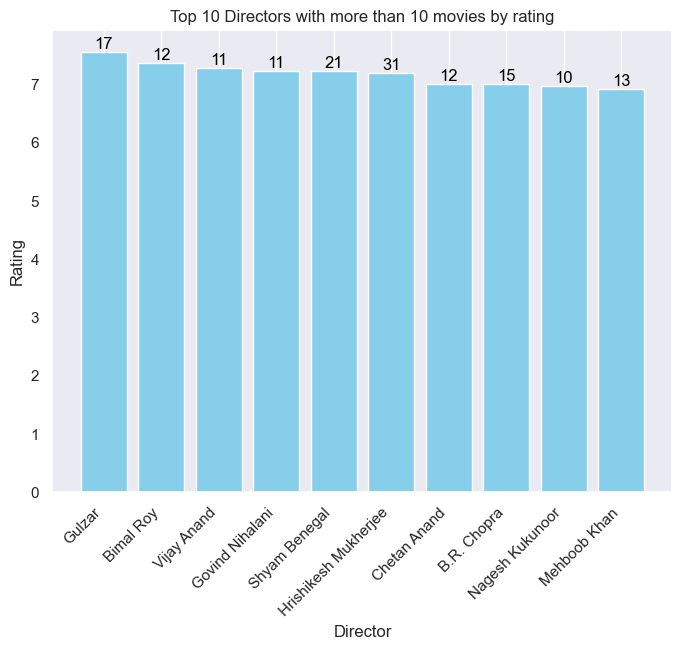

In [698]:
top_10_director = top_10_rating("Director") 
plt.figure(figsize=(8, 6))
bars = plt.bar(top_10_director['Director'], top_10_director['mean'], color='skyblue')
plt.xlabel('Director')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
for bar, count in zip(bars, top_10_director['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), count,
             ha='center', va='bottom', color='black')
plt.title('Top 10 Directors with more than 10 movies by rating')
plt.show()

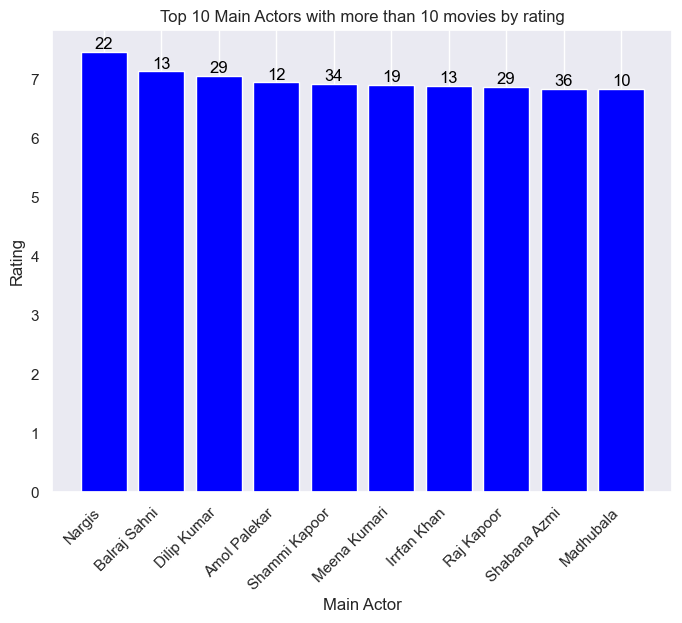

In [699]:
top_10_actors1 = top_10_rating("Actor 1") 
plt.figure(figsize=(8, 6))
bars = plt.bar(top_10_actors1['Actor 1'], top_10_actors1['mean'], color='blue')
plt.xlabel('Main Actor')
plt.ylabel('Rating')
plt.title('Top 10 Main Actors with more than 10 movies by rating')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

for bar, count in zip(bars, top_10_actors1['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), count,
             ha='center', va='bottom', color='black')
plt.show()

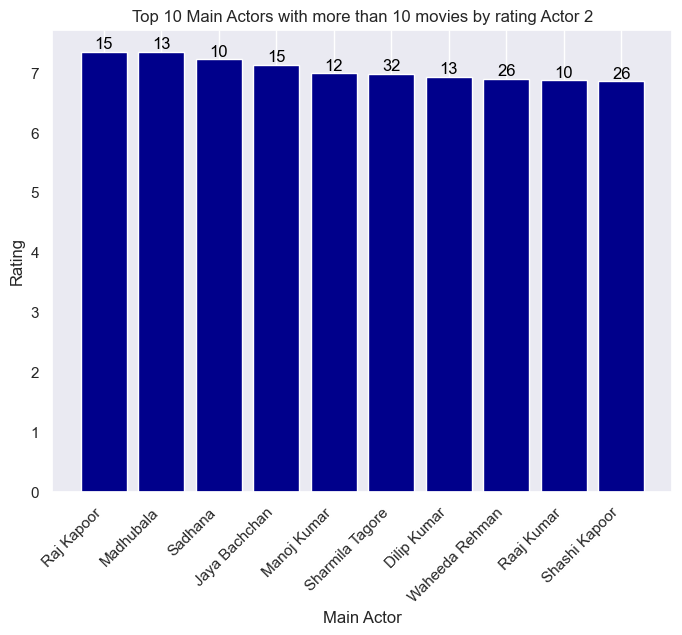

In [700]:
top_10_actors1 = top_10_rating("Actor 2") 
plt.figure(figsize=(8, 6))
bars = plt.bar(top_10_actors1['Actor 2'], top_10_actors2['mean'], color='darkblue')
plt.xlabel('Main Actor')
plt.ylabel('Rating')
plt.title('Top 10 Main Actors with more than 10 movies by rating Actor 2')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

for bar, count in zip(bars, top_10_actors1['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), count,
             ha='center', va='bottom', color='black')
plt.show()

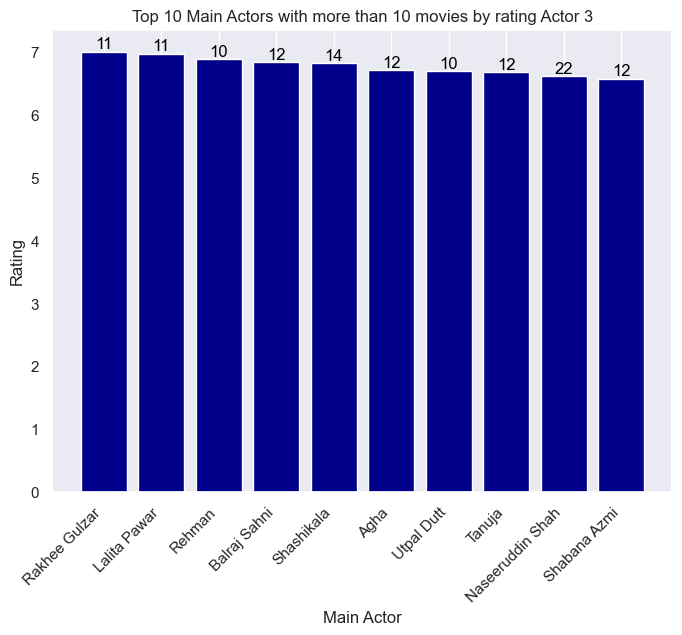

In [701]:
top_10_actors3 = top_10_rating("Actor 3") 
plt.figure(figsize=(8, 6))
bars = plt.bar(top_10_actors3['Actor 3'], top_10_actors3['mean'], color='darkblue')
plt.xlabel('Main Actor')
plt.ylabel('Rating')
plt.title('Top 10 Main Actors with more than 10 movies by rating Actor 3')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

for bar, count in zip(bars, top_10_actors3['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), count,
             ha='center', va='bottom', color='black')
plt.show()

In [702]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('Median absolute error: ',round(median_absolute_error,4))

In [703]:
# df =df.drop(columns=["Name","Main_genre"])

In [704]:
X = df.drop(columns="Rating")
y = df["Rating"]

In [705]:
encoder = ce.JamesSteinEncoder(return_df=True)

In [706]:
encoder.fit(X,y)
X = encoder.transform(X.loc[:,:])

In [707]:
scaler = RobustScaler()
scaler.fit(X)
X.loc[:,:] = scaler.transform(X.loc[:,:])

In [708]:
X

,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3
0,0.59375,-0.806452,0.673108,-0.172043,1.048320,1.011361,1.151748,1.161557
1,0.59375,-0.774194,-0.265848,-0.123656,-1.337036,-0.703284,-1.478136,-1.449546
2,-0.09375,0.419355,0.050431,1.295699,-0.268999,-0.673367,-0.348098,-0.120334
3,0.15625,0.258065,1.100447,1.759857,1.415298,-0.252415,0.832549,0.305192
4,0.37500,-1.677419,-0.283943,0.397849,-0.236103,-0.280279,-0.014266,-0.274124
...,...,...,...,...,...,...,...,...
5652,0.46875,-0.612903,0.673108,0.544803,0.222620,0.252585,0.241404,-0.019455
5653,0.03125,0.612903,1.365760,2.494624,0.982671,-0.680902,-0.054848,-0.021356
5654,-0.34375,-0.290323,-0.309461,-0.107527,0.306536,0.344705,-0.062045,0.139199
5655,-0.03125,-0.161290,-0.342066,0.987455,-0.452291,-0.692763,-0.968549,-0.092566


In [709]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7,shuffle=True)

In [710]:
#XGB regressor model

In [711]:
xgb_model = XGBRegressor(objective ='reg:squarederror',gamma=0.09,learning_rate=0.08,subsample=0.7)

In [712]:
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.09, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [713]:
xgb_model.score(X_train,y_train)

0.9367704478322231

In [714]:
xgb_model.score(X_test,y_test)

0.8772586425133556

In [715]:
#LGM model

In [716]:
y_pred = xgb_model.predict(X_test)
print(f"Report:Lgbm model")
print(f"{regression_results(y_test, y_pred)}\n")

Report:Lgbm model
explained_variance:  0.8773
mean_squared_log_error:  0.0062
r2:  0.8773
MAE:  0.3177
MSE:  0.2207
RMSE:  0.4698
Median absolute error:  0.198
None



In [717]:
score = cross_val_score(xgb_model,X,y,cv=10)
avg = np.mean(score)
print(f"cross validation score for XGBoost:{score}")
print(f"average cross validation score for XGBoost:{avg}\n")

cross validation score for XGBoost:[0.86663335 0.86708287 0.87071149 0.88047657 0.8755393  0.87982714
 0.85685813 0.86187225 0.85626878 0.8897919 ]
average cross validation score for XGBoost:0.8705061776575477



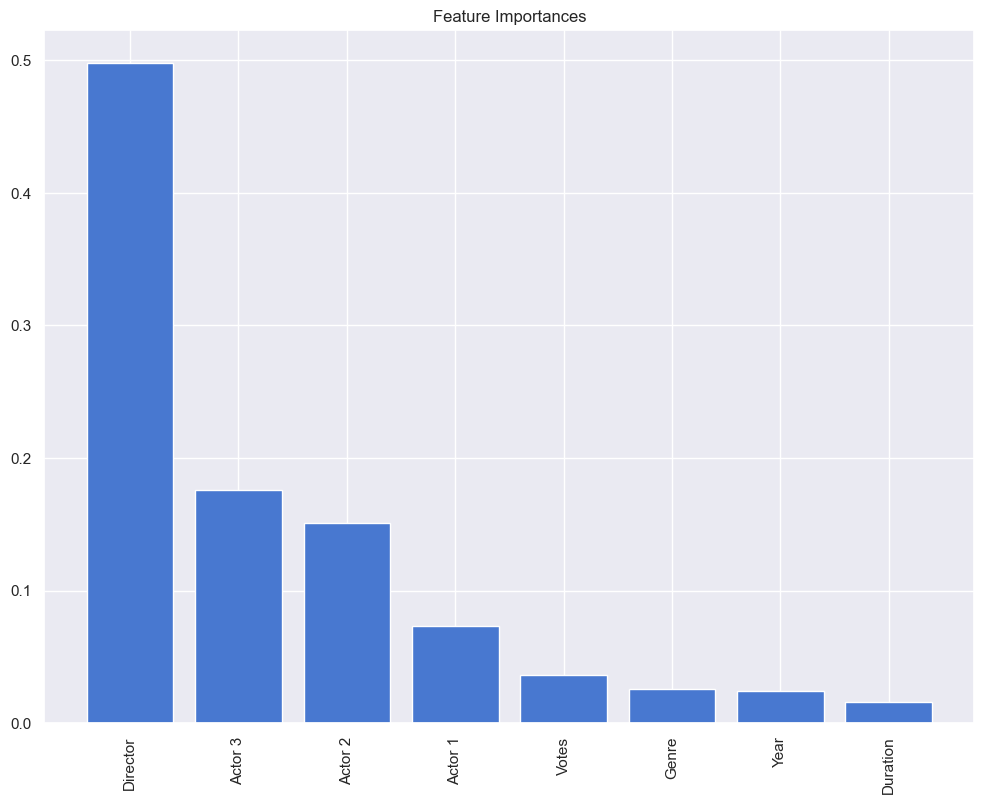

In [718]:
fs = xgb_model.feature_importances_
feature_names = X.columns

feature_importances = pd.DataFrame(fs,feature_names).sort_values(by=0,ascending=False)
plt.figure(figsize=(12, 9))
plt.title("Feature Importances")
plt.bar(x=feature_importances.index,height=feature_importances[0])
plt.xticks(rotation=90)

plt.show()

In [719]:
df.head()

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
2,1997,147,"Comedy, Drama, Music",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
3,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
4,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [720]:
new_df = pd.DataFrame({'Year':[2007],'Duration':[136],\
                         'Genre':'Comedy,Drama','Votes':[7123],'Director':['Indra Kumar'],\
                         'Actor 1':['Sanjay Datt'],'Actor 2':[' Riteish Deshmukh'],'Actor 3':['Arshad Warsi'],})

In [721]:
new_df = encoder.transform(new_df)
new_df.loc[:,:] = scaler.transform(new_df.loc[:,:])

In [722]:
new_df

,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3
0,0.21875,0.064516,0.015047,12.578853,-0.491735,-0.043761,-0.037432,-0.691475


In [723]:
xgb_model.predict(new_df)

array([5.5663605], dtype=float32)